In [ ]:
#pattern recognition 透過學習已知服裝圖片與標籤，可訓練出model用來辨識其他未知服飾圖片的服裝特徵pattern

In [1]:
from fastai.vision.all import *
import gc 
import os

In [2]:
PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/"
TRAIN_PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/attribute_train/train_labels.csv"
TEST_PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/attribute_train/test_labels.csv"
CLASSES_PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/attribute_train/pattern_labels.txt"


In [ ]:
#讀入資料集

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
train_df['is_valid'] = train_df['is_valid'].astype(int)
train_df.head()
print(len(train_df))

47708


In [4]:
count=0
for i in train_df['image_name']:
    if os.path.exists(PATH+i):
        if os.path.isfile(PATH+i):
            next
    else:
        train_df = train_df.drop(index=[count])
    count += 1
train_df=train_df.reset_index(drop=True)
print(len(train_df))

47686


In [4]:
def get_x(r): return PATH+r['image_name']
def get_y(r): return r['labels'].split(';')

In [5]:
def splitter(df):
    train = df.index[df['is_valid']==0].tolist()
    valid = df.index[df['is_valid']==1].tolist()
    return train,valid

In [ ]:
#設定fastai data block

In [6]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(224, min_scale=0.8),
                   batch_tfms=aug_transforms())

dls = dblock.dataloaders(train_df, num_workers=0)

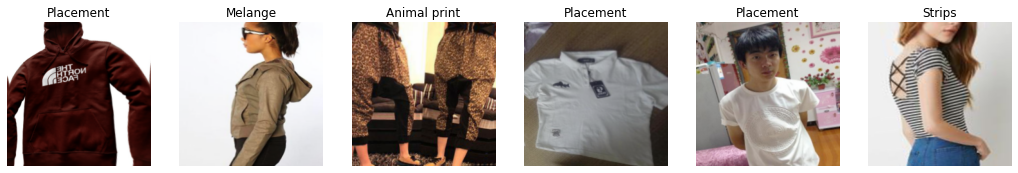

In [8]:
dls.show_batch(nrows=1, ncols=6)

In [9]:
dsets = dblock.datasets(train_df)

In [10]:
dsets.train[0]

(PILImage mode=RGB size=600x600,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]))

In [ ]:
#設定新的衡量函數

In [11]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

如果使用fastai 預設的衡量函數，會發生預測準確率極高的偏誤

<h2>更改loss function</h2>
 

In [17]:
dsets.train[0]

(PILImage mode=RGB size=600x600,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]))

In [18]:
dls.vocab

['Abstract', 'Animal print', 'Camouflage', 'Floral', 'Geometric', 'Gradient', 'IKAT', 'Melange', 'Paisley', 'Placement', 'Plaids', 'Scenery', 'Solid', 'Spots', 'Strips', 'Tropical']

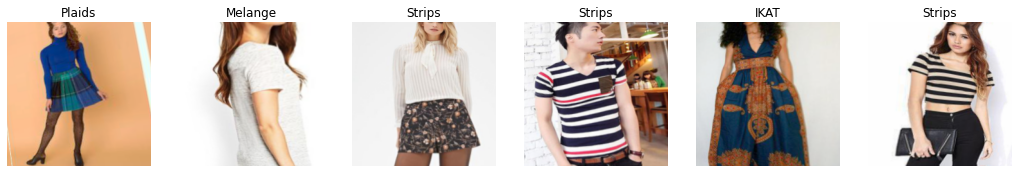

In [19]:
dls.show_batch(nrows=1, ncols=6)

<p> 這個資料集中，有些分類是模糊或錯誤的(充滿雜訊，因此會增加我們訓練的難度). 使用label soomthing  <a href="https://arxiv.org/pdf/1906.02629.pdf"></a>.</p> <p>Labels smoothing 可以避免overfit.

In [20]:
class LabelSmoothingBCEWithLogitsLossFlat(BCEWithLogitsLossFlat):
    def __init__(self, eps:float=0.1, **kwargs):
        self.eps = eps
        super().__init__(thresh=0.2, **kwargs)
    
    def __call__(self, inp, targ, **kwargs):
        targ_smooth = targ.float() * (1. - self.eps) + 0.5 * self.eps
        return super().__call__(inp, targ_smooth, **kwargs)
    
    def __repr__(self):
        return "FlattenedLoss of LabelSmoothingBCEWithLogits()"

In [21]:
metrics=[FBetaMulti(2.0, 0.2, average='samples'), partial(accuracy_multi, thresh=0.2)]

In [22]:
wd      = 5e-7 #weight decay parameter
opt_func = partial(ranger, wd=wd)

In [ ]:
#建立fastau learner model ，並使用 resnet34 作為pretrained model

In [23]:
learn = cnn_learner(dls, resnet34, loss_func=LabelSmoothingBCEWithLogitsLossFlat(),
            metrics=metrics, opt_func=opt_func).to_fp16()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=7.585775892948732e-05)

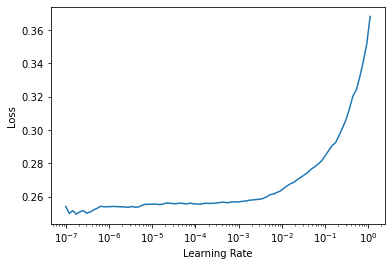

In [156]:
learn.unfreeze()
learn.lr_find()

In [25]:
learn = cnn_learner(dls, resnet34, loss_func=LabelSmoothingBCEWithLogitsLossFlat(),
            metrics=metrics, opt_func=opt_func).to_fp16()
learn = learn.load(file='C:/Users/Alan/Desktop/fashion_classification/attribute/models/atr-recognition-stage-1-resnet34')

In [26]:
learn.fit_one_cycle(8, lr_max=slice(1e-7, 1e-4))
learn.save('atr-recognition-stage-2-resnet34')



epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.255790,0.249450,0.812495,0.957379,08:42
1,0.254162,0.249186,0.813779,0.957535,08:42
2,0.254607,0.248865,0.814310,0.957379,08:47
3,0.252616,0.249082,0.813750,0.957249,09:17
4,0.253777,0.248988,0.811879,0.956867,09:26
5,0.253650,0.249028,0.813031,0.956780,09:27
6,0.252985,0.248914,0.812611,0.956884,09:26
7,0.252180,0.248801,0.814008,0.957162,09:28


OSError: [Errno 22] Invalid argument: 'C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/attribute_train/pattern_labels.txt'

In [23]:
learn = cnn_learner(dls, resnet34, loss_func=LabelSmoothingBCEWithLogitsLossFlat(),
            metrics=metrics, opt_func=opt_func).to_fp16()
learn = learn.load(file='C:/Users/Alan/Desktop/fashion_classification/attribute/models/atr-recognition-stage-2-resnet34')

In [24]:
modelname = learn.model
modelname.cpu()
torch.save(modelname, 'atr-recognition-stage-2-resnet34.pkl')

with open(CLASSES_PATH, 'w') as f:
    for item in dls.vocab:
        f.write("%s\n" % item)

In [25]:
learn.validate()

(#3) [0.26707732677459717,0.7366608259465403,0.9495435953140259]

In [ ]:
#訓練結果

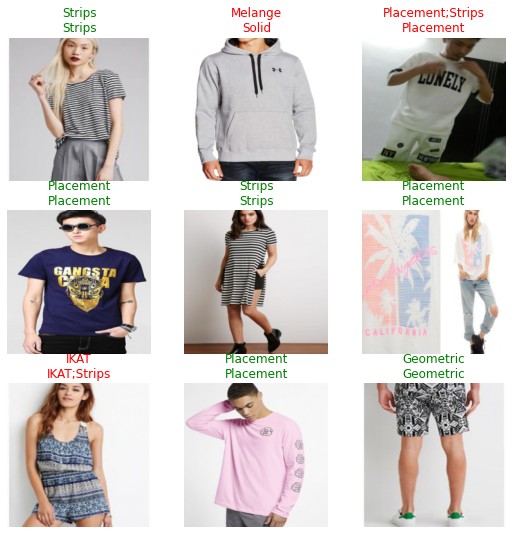

In [29]:
learn.show_results()

<p>Our predictions do not match the labels exactly, but the predicted labels make sense. Overall our model captures the main concepts.</p>

<h3>測試資料</h3>


In [33]:
test_df = pd.read_csv(TEST_PATH)
test_df.head()

,image_name,labels
0,img\Sheer_Pleated-Front_Blouse\img_00000005.jpg,"feather,pleated"
1,img\Sheer_Pleated-Front_Blouse\img_00000007.jpg,"pleated,sheer"
2,img\Sheer_Pleated-Front_Blouse\img_00000013.jpg,sheer
3,img\Sheer_Pleated-Front_Blouse\img_00000019.jpg,pleated
4,img\Sheer_Pleated-Front_Blouse\img_00000020.jpg,sheer


In [34]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(224)) # Not Sure)

test_dls = dblock.dataloaders(test_df, num_workers=0)

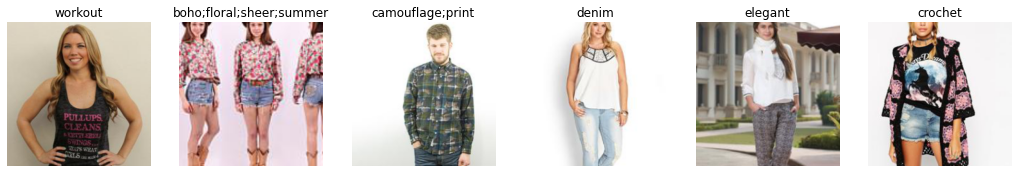

In [35]:
test_dls.show_batch(nrows=1, ncols=6)

In [36]:
learn.data = test_dls
learn.validate()

(#3) [0.22433756291866302,0.44253026656767896,0.9837779402732849]

<p>The model still shows a good FBeta on the test dataset.</p>

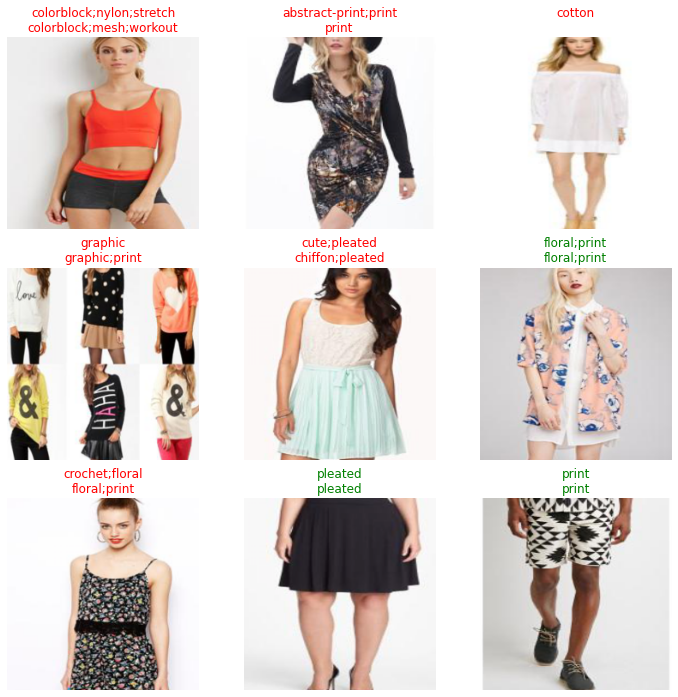

In [37]:
learn.show_results(figsize=(12,12))